Part 4 - Reconstructing a Stimulus
====================================



In this exercise, you will use the same method as Pipa et al. in the 2012 paper <a href="http://www.mitpressjournals.org/doi/abs/10.1162/NECO_a_00334">Precise mapping of V1 receptive fields by tomographic reconstruction</a>.

A light bar of angle $\alpha$ pans slowly from left to right over the visual field. At some point in time, the recorded cell will respond with an increase in firing rate.

Your goal is to fit a rate function that is sensitive enough to find the point of increased firing rate and then compute the position of the receptive field within the visual field.

In [1]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np
import splines
from scipy.ndimage.filters import gaussian_filter1d
def reduce_resolution(array,factor,sum_spikes=True):
    """ 
    Reduces the temporal resolution of an array of spike trains.
    
    This can cause multiple spikes to fall into one time bin, i.e. the
    returned array can contain integers > 1.
    If sum_spikes is set to False, we do not sum spike counts. Instead,
    any spike counts > 1 in one bin are truncated down to 1. In that case,
    a binary array is returned, but some spikes may be lost.
    
    Arguments:
        array: 4D numpy array. Reduction will occur along the last dimension (T).
        factor: integer to divide the number of time bins by.
        sum_spikes: If false, truncate the number of spikes per bin to 1.
      
    Returns:
        4D numpy array, similar as input but last dimension with length T/factor.
    """
    assert type(factor) is int
    reduced_shape = (array.shape[0],array.shape[1],array.shape[2],array.shape[3]/np.round(factor))
    spikes_reduced = np.zeros(reduced_shape) # create a shortened result array
    for idx in np.ndindex(array.shape[0:3]): # for all indices along the first 3 dimensions..
        spiketimes = (array[idx].nonzero()[0] / factor).astype(int) # get spiketimes, divide by factor
        for spiketime in spiketimes[spiketimes<spikes_reduced.shape[-1]]: # loop manually, since numpy indexing treats index lists as sets
            spikes_reduced[idx[0],idx[1],idx[2],spiketime] += 1 # increment result array by 1 at the divided spiketimes
    
    if not sum_spikes:
        spikes_reduced  = spikes_reduced >= 1
    spikecount_difference = (np.sum(array) - np.sum(spikes_reduced)).astype(int)
    if spikecount_difference > 0:
        print "Lost "+str(spikecount_difference)+" spikes through resolution reduction."
    return spikes_reduced    

def find_percentiles(y, num_percentiles, return_thresholds=False):
    """ Finds `num_percentiles` equally spaced percentiles of `y` (a monotonically increasing vector),
    i.e. it approximates the inverse `x` of the function `y=f(x)` 
    at `num_percentiles` equally spaced `y`-values between 0 and `y[-1]`.
    
    Arguments:
        y:                  a sequence of monotonically increasing function values
        num_percentiles:    number of percentiles to find between 0 and `y[-1]`.
        return_threshold:   boolean value to indicated whether or not to return the thresholds, too
    Returns:
        percentiles:        `y`-values of the percentiles
        [thresholds:        `x`-values of the percentiles]
    """
    thresholds = np.linspace(0,y[-1],num_percentiles+1)
    percentiles = np.zeros_like(thresholds)
    
    current = 1
    for step in range(T):
        if y[step] > thresholds[current]:
            percentiles[current] = step
            current +=1
    
    percentiles[-1] = len(y)
    if return_thresholds:
        return percentiles, thresholds
    else:
        return percentiles

def calc_cum_abs_deriv(y, sigma=10, order=1):
    """ Calculates the curvature of the spike count vector `y`"""
    return np.cumsum(np.abs(gaussian_filter1d(y, sigma=sigma, order=order)))

In [2]:
# Load the data:
with np.load('data_movingbar_c16.npz') as archive:
    original_spikes = archive['spikes_movingbar']
    

# reduce resolution:
resolution_reduction = 20 # <-- resolution reduction factor
spikes = reduce_resolution(original_spikes,factor=resolution_reduction, sum_spikes=True)
    
n_conditions = spikes.shape[1]
N = spikes.shape[2] # number of trials
T = spikes.shape[3] # length of a trial

Lost 8 spikes through resolution reduction.


In [3]:
n_conditions

36

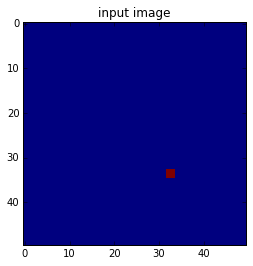

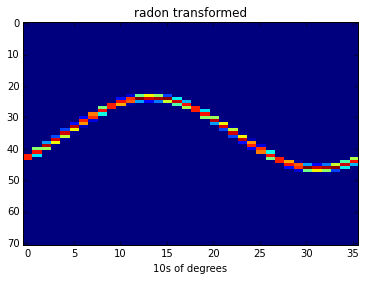

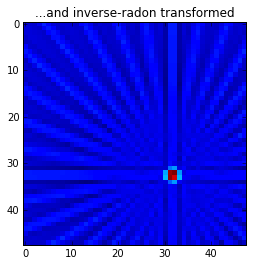

In [4]:
from skimage.transform.radon_transform import radon,iradon

bla = np.zeros((50,50))
bla[33,32] = 1
bla[33,33] = 1
bla[34,32] = 1
bla[34,33] = 1

figure()
imshow(bla,interpolation='nearest')
title("input image")

figure()
radon_image = radon(bla,np.arange(0,360,10))
imshow(radon_image,aspect='auto',interpolation='nearest')
title("radon transformed")
xlabel("10s of degrees")

figure()
f = iradon(radon_image, 360*np.arange(0,n_conditions)/n_conditions) # solution
imshow(f[1:-1,1:-1],interpolation='nearest')
title("...and inverse-radon transformed")




In [5]:
import statsmodels.api as sm

def get_dm_rate(summed_spikecount):
    num_knots = 16
    spline_order = 3
    sigma = 100/resolution_reduction
    cumulative = np.cumsum(np.abs(gaussian_filter1d(summed_spikecount, sigma=sigma, order=0)))
    knots   = find_percentiles(cumulative, num_knots)
    knots = splines.augknt(knots, spline_order)
    return np.array(splines.spcol(range(T),knots,spline_order))
  

def get_hist_bases():
    history_length = 100/resolution_reduction
    history_spline_order = 3                          
    history_num_knots = 4       
    
    history_knots = splines.augknt(np.logspace(0,np.log10(history_length),history_num_knots),history_spline_order)
    history_knots = history_knots[:-1]

    history_x = np.linspace(1+1e-10,history_length,history_length)                                 
    return splines.spcol(history_x,history_knots,history_spline_order)
    

def get_dm_ahist(spiketrain):
    hist_bases = get_hist_bases()
    num_history_bases = hist_bases.shape[1]
    hist_cell_dm = np.zeros((len(spiketrain),num_history_bases))    
    for i in range(num_history_bases):
        padded_kernel = np.hstack([np.zeros_like(hist_bases[:,i]),hist_bases[:,i]])
        hist_cell_dm[:,i] = np.convolve(spiketrain, padded_kernel, "same")
    return hist_cell_dm

def fit_rate_only(spikes_singlecondition):
    assert spikes_singlecondition.shape == (N,T)
    sigma = 100/resolution_reduction
    summed_spikecount = np.sum(spikes_singlecondition,axis=0)
    dm = get_dm_rate(summed_spikecount)
    
    spikes_nospikes = np.vstack([summed_spikecount, N*resolution_reduction-summed_spikecount]).T    
    model = sm.GLM(spikes_nospikes,dm,family=sm.families.Binomial())
    fitted_model = model.fit()
    prediction = fitted_model.predict(dm)
    prediction[0] = 0
    return prediction



def fit_rate_absorb_history(spikes_singlecondition):
    assert spikes_singlecondition.shape == (N,T)
    spline_order = 3
    summed_spikecount = np.sum(spikes_singlecondition,axis=0)
    chained_trials = spikes_singlecondition.ravel()
    dm_ahist = get_dm_ahist(chained_trials)
    num_history_bases = dm_ahist_.shape[1]
    dm_rate = get_dm_rate(summed_spikecount)
    dm = np.hstack([dm_ahist,np.tile(dm_rate_,(N,1))])

    spikes_nospikes = np.vstack([chained_trials, resolution_reduction-chained_trials]).T    
    model = sm.GLM(spikes_nospikes,dm,family=sm.families.Binomial())
    fitted_model = model.fit()
    # # explicit version:
    # rateparams = fitted_model.params[num_history_bases:]
    # eta_rate = np.dot(dm_rate_,rateparams)
    # prediction = 1/(1+np.exp(-eta_rate))
    # # -> equivalent to zeroing the respective DM columns:
    prediction = fitted_model.predict(np.hstack([np.zeros((T,num_history_bases)),dm_rate]))
    prediction[0] = 0
    return prediction


preds_rate = []
n_conditions = 36
for i in range(n_conditions):
    preds_rate.append(fit_rate_only(spikes[0,i,:,:]))

    
preds_rate_absorb_history = []
for i in range(n_conditions):
    preds_rate_absorb_history.append(fit_rate_absorb_history(spikes[0,i,:,:]))


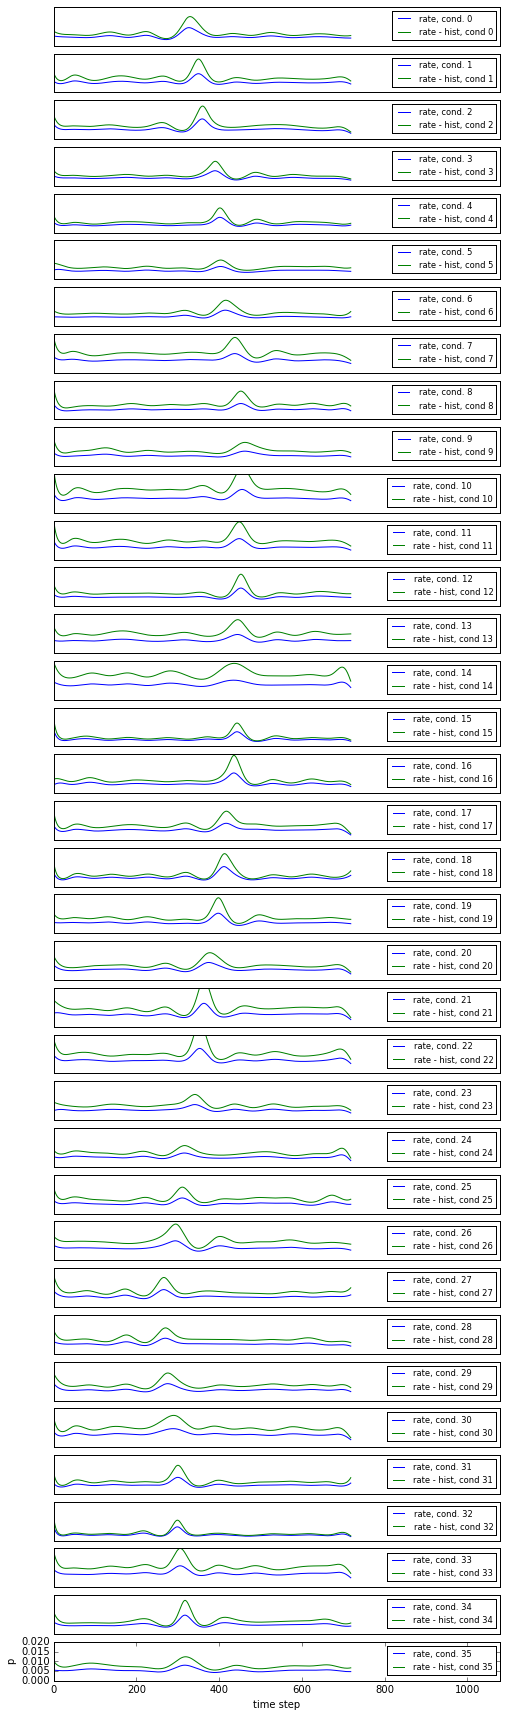

In [6]:
figure(figsize=(8,30))
for i in range(n_conditions):
    subplot(n_conditions,1,i+1)
    plot(preds_rate[i],label='rate, cond. '+str(i))
    plot(preds_rate_absorb_history[i],label='rate - hist, cond '+str(i))    
    xlim((0,T*1.5))
    ylim(0,0.02)
    legend(fontsize='small')
    if i != n_conditions-1:
        xticks([])
        yticks([])
    else:
        xlabel("time step")
        ylabel("p")

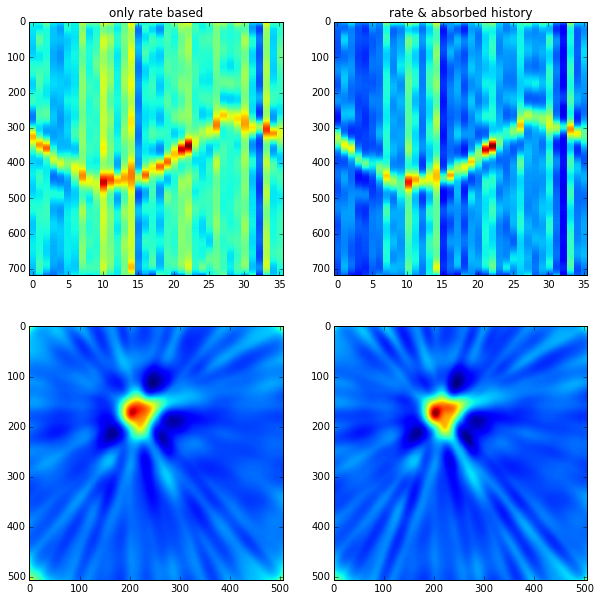

In [8]:
radonimage_rate = np.array(preds_rate).T
radonimage_rate_absorb_hist = np.array(preds_rate_absorb_history).T

figure(figsize=(10,10))

# only rate based
subplot(2,2,1)
title("only rate based")
imshow(radonimage_rate,aspect='auto',interpolation='nearest')
subplot(2,2,3)
f = iradon(radonimage_rate, 360*np.arange(0,n_conditions)/n_conditions)
imshow(f[1:-1,1:-1],interpolation='nearest')


# rate & absorb history
subplot(2,2,2)
title("rate & absorbed history")
imshow(radonimage_rate_absorb_hist,aspect='auto',interpolation='nearest')
subplot(2,2,4)
f = iradon(radonimage_rate_absorb_hist, 360*np.arange(0,n_conditions)/n_conditions)
imshow(f[1:-1,1:-1],interpolation='nearest')

